<h1 style="font-size:40px; text-align: center; margin-bottom: 10px;">Of Immigrants and Oligarchs: Detecting AGN Migration Trap Binaries with LISA</h1>
<p style="text-align: center;">Plots associated with paper</p>

In [101]:
import h5py as h5
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from scipy import stats

import astropy.cosmology as cosmo
import os

import time
import sys

# my helper functions
sys.path.append("../src/")
import legwork
import helpers

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

# Binary Hardening Rate
Exploration of how the binary hardening rate changes

In [2]:
def r_g(m_smbh=1e8 * u.Msun):
    """
        Calculate gravitational radius (half the Schwartzchild radius) given the mass of central supermassive black hole
        
        Args:
            m_smbh --> [list of floats] Mass of central supermassive black hole
            
        Returns:
            r_g    --> [list of floats] Gravitational radius
    """
    return (c.G * m_smbh / c.c**2).to(u.AU)

def hill_radius(a, m_bin=1e2 * u.Msun, m_smbh=1e8 * u.Msun):
    """
        Calculate the Hill radius for a potential binary
        
        Args:
            a      --> [list of floats] Galactocentric radius of the binary
            m_bin  --> [list of floats] Mass of the binary 
            m_smbh --> [list of floats] Mass of the central supermassive black hole
            
        Returns:
            a_hill --> [list of floats] Hill radius for the binary
    """
    return a * (1/3 * m_bin / m_smbh)**(1/3)

def t_hard_gas(T=10000*u.K, Sigma=1e7*u.kg/u.m**2, a_bin=50*u.AU, a=700*u.AU, m_smbh=1e8*u.Msun, m_bin=1e2*u.Msun):
    """
        Calculate the hardening timescale for a binary embedded in a disc of gas
        Baruteau+11 Eq.11/12
        
        Args:
            T      --> [float]          Unperturbed gas temperature at binary's location
            Sigma  --> [float]          Disc surface density at binary's location
            a_bin  --> [list of floats] Binary semi-major axis
            a      --> [float]          Galactocentric radius of the binary
            m_smbh --> [float]          Mass of the central supermassive black hole
            m_bin  --> [float]          Mass of the binary
            
        Returns:
            tau    --> [list of floats] Hardening timescale
    """
    # calculate angular orbital frequency and mass ratio
    Omega = np.sqrt((c.G * (m_smbh + m_bin)) / a**3).to(u.Hz)
    q = m_bin / m_smbh
    
    # return the hardening timescale
    return (1.2 * c.k_B**3 / (c.G * c.m_p**3) * T**3 / Sigma * a_bin / a**6 / Omega**5 / q**2).to(u.s)

def t_hard_cavity(T=10000*u.K, Sigma=1e7*u.kg/u.m**2, a_bin=50*u.AU, m_bin=1e2*u.Msun, alpha=1e-3):
    """
        Calculate the hardening timescale for a binary in a cavity surrounded by gas
        Baruteau+11 Eq.13/14
        
        Args:
            T     --> [float]          Unperturbed gas temperature at binary's location
            Sigma --> [float]          Disc surface density at binary's location
            a_bin --> [list of floats] Binary semi-major axis
            m_bin --> [float]          Mass of the binary
            alpha --> [float]          Constant involved in calculating kinematic viscosity
            
        Returns:
            tau   --> [list of floats] Hardening timescale
    """
    return (90 * u.Myr * (alpha / 1e-3)**(-1) * (T / (2e3*u.K))**(-1) * (m_bin / (30*u.Msun))**(3/2)
            * (Sigma / (1e2*u.g / u.cm**2))**(-1) * (a_bin / (100*u.AU))**(-3/2)).to(u.Myr)

def t_hard(T=10000*u.K, Sigma=1e7*u.kg/u.m**2, a_bin=50*u.AU, a=700*u.AU, m_smbh=1e8 * u.Msun, m_bin=1e2*u.Msun, alpha=1e-3):
    """
        Calculate the hardening timescale for a binary due to gas
        
        Args:
            T      --> [float]          Unperturbed gas temperature at binary's location
            Sigma  --> [float]          Disc surface density at binary's location
            a_bin  --> [list of floats] Binary semi-major axis
            a      --> [float]          Galactocentric radius of the binary
            m_smbh --> [float]          Mass of the central supermassive black hole
            m_bin  --> [float]          Mass of the binary
            alpha  --> [float]          Constant involved in calculating kinematic viscosity
            
        Returns:
            tau    --> [list of floats] Hardening timescale
    """
    # transition occurs at a sixth of the Hill radius
    times = np.zeros(len(a_bin)) * u.s
    transition = hill_radius(a, m_bin, m_smbh) / 6
    
    # calculate both timescales and return them
    times[a_bin > transition] = t_hard_gas(T=T, Sigma=Sigma, a_bin=a_bin[a_bin > transition], a=a, m_smbh=m_smbh, m_bin=m_bin)
    times[a_bin <= transition] = t_hard_cavity(T=T, Sigma=Sigma, a_bin=a_bin[a_bin <= transition], m_bin=m_bin, alpha=alpha)
    return times

def t_hard_tapered(T=10000*u.K, Sigma=1e7*u.kg/u.m**2, a_bin=50*u.AU, a=700*u.AU, m_smbh=1e8 * u.Msun, m_bin=1e2*u.Msun, alpha=1e-3, smooth=1e-3):
    """
        Calculate the hardening timescale for a binary due to gas with a smooth taper between the two types
        
        Args:
            T      --> [float]          Unperturbed gas temperature at binary's location
            Sigma  --> [float]          Disc surface density at binary's location
            a_bin  --> [list of floats] Binary semi-major axis
            a      --> [float]          Galactocentric radius of the binary
            m_smbh --> [float]          Mass of the central supermassive black hole
            m_bin  --> [float]          Mass of the binary
            alpha  --> [float]          Constant involved in calculating kinematic viscosity
            smooth --> [float]          How much to smooth the transition
            
        Returns:
            tau    --> [list of floats] Hardening timescale
    """
    transition = hill_radius(a, m_bin, m_smbh) / 6
    gas = t_hard_gas(T=T, Sigma=Sigma, a_bin=a_bin, a=a, m_smbh=m_smbh, m_bin=m_bin)
    cavity = t_hard_cavity(T=T, Sigma=Sigma, a_bin=a_bin, m_bin=m_bin, alpha=alpha)
    return gas + (1 + np.tanh(-smooth * (a_bin - transition).value)) / 2 * (cavity - gas)

def t_GW(a_bin, m_bin=100*u.Msun):
    """
        Calculate the hardening timescale due to gravitational waves
        
        Since mass ratio doesn't affect inspiral time, we can assume equal mass ratio here
        
        Args:
            a_bin --> [list of floats] Binary semi-major axis
            m_bin --> [float]          Mass of the binary
            
        Returns:
            tau   --> [list of floats] Hardening timescale
    """
    return legwork.evol.get_t_merge_circ(a_i=a_bin, m_1=m_bin/2, m_2=m_bin/2).to(u.yr)

def dadt_gas_hardening(a_bin, smooth=1e-3):
    return - (a_bin / t_hard_tapered(a_bin=a_bin, smooth=smooth)).to(u.Rsun / u.yr)

def dadt_GW_hardening(a_bin, m_bin=100*u.Msun, e=0.0):
    m1, m2 = m_bin/2, m_bin/2
    return - (legwork.utils.beta(m1, m2) / a_bin**3 * legwork.utils.peters_f(e)).to(u.Rsun / u.yr)

Same plot, one panel, time labels

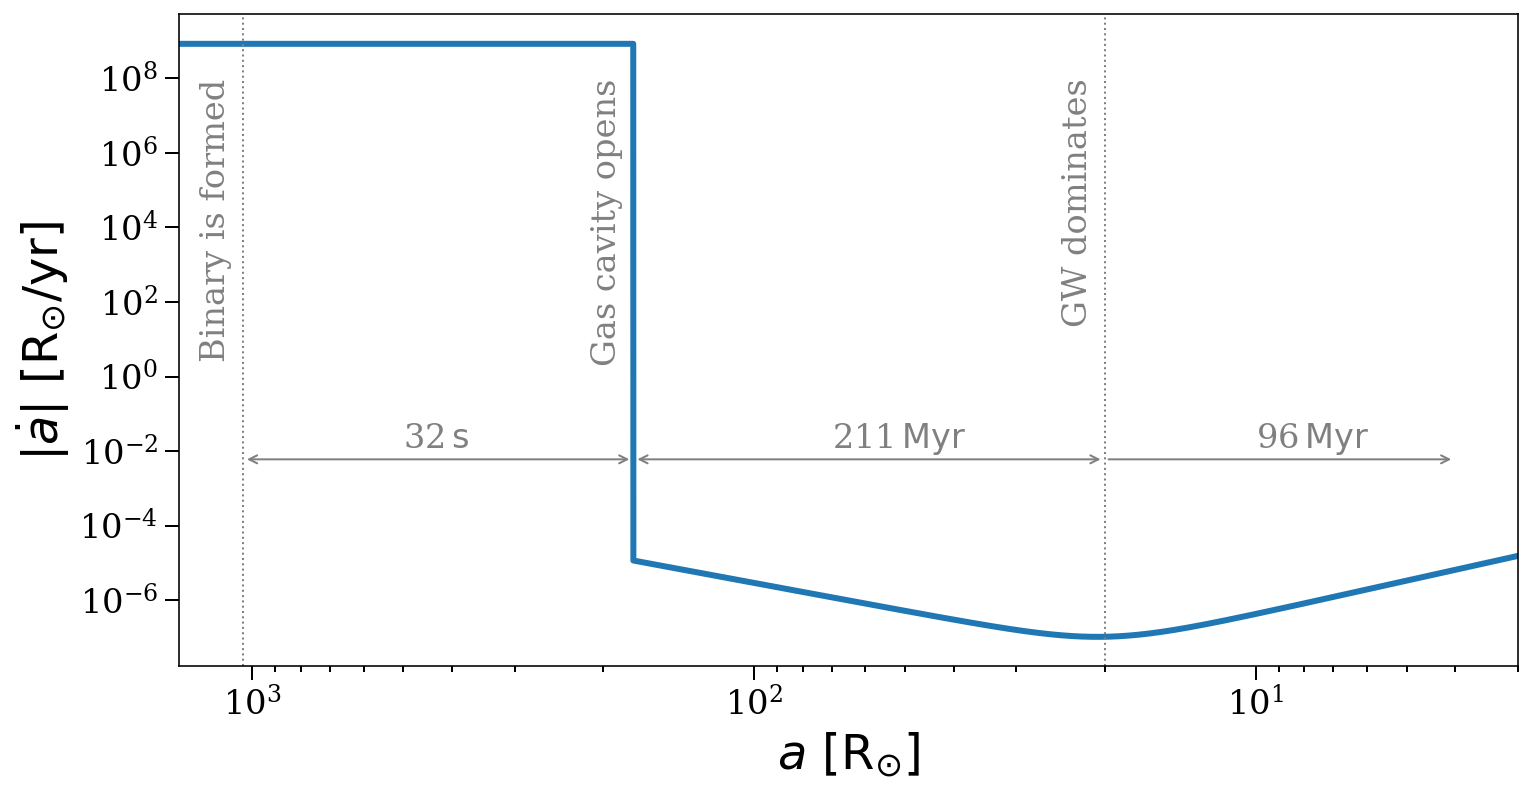

In [5]:
a_bin_range = np.logspace(np.log10(3), 3.2, 50000) * u.Rsun
a = 700 * u.AU
hill_sphere = hill_radius(a, 1e2, 1e8).to(u.Rsun)
smooth = 1e3

fig, ax = plt.subplots(figsize=(12, 6))

rate = np.add(-dadt_gas_hardening(a_bin=a_bin_range, smooth=smooth).to(u.Rsun / u.yr), -dadt_GW_hardening(a_bin=a_bin_range).to(u.Rsun / u.yr))

ax.loglog(a_bin_range, rate, label="Dominant Hardening Rate", lw=3)
ax.set_ylabel(r"$|\dot{a}| \ [\rm R_{\odot} / yr]$", fontsize=fs)

ratio = (dadt_gas_hardening(a_bin=a_bin_range, smooth=smooth).to(u.Rsun / u.yr) / dadt_GW_hardening(a_bin=a_bin_range).to(u.Rsun / u.yr)).decompose()

gas_cavity_transition = hill_sphere / 6
cavity_GW_transition = a_bin_range[np.abs(ratio - 1.0).argmin()]

ax.axvline(hill_sphere.value, 0, 1, linestyle="dotted", color="grey", lw=1)
ax.axvline(cavity_GW_transition.value, 0, 1, linestyle="dotted", color="grey", lw=1)

ax.annotate("Binary is formed", xy=(hill_sphere.value * 1.05, 1e8), va="top", ha="right", rotation=90, fontsize=0.7 * fs, color="grey")
ax.annotate("Gas cavity opens", xy=(gas_cavity_transition.value * 1.05, 1e8), va="top", ha="right", rotation=90, fontsize=0.7 * fs, color="grey")
ax.annotate("GW dominates", xy=(cavity_GW_transition.value * 1.05, 1e8), va="top", ha="right", rotation=90, fontsize=0.7 * fs, color="grey")

height = 6e-3
arrow_lw = 1

time_to_open_cavity = (hill_sphere * (1 - 1/6) / rate[-1]).to(u.s)
ax.annotate("{0:1.0f}".format(time_to_open_cavity.value) + r"$\,{\rm s}$", xy=(5e2, 2 * height), fontsize=0.7*fs, color="grey")
ax.annotate("",
                xy=(hill_sphere.value, height), xytext=(gas_cavity_transition.value, height),
                arrowprops=dict(arrowstyle="<->", color="grey", lw=arrow_lw))

# height *= 1/2

intermediate_rate = rate[np.logical_and(a_bin_range < gas_cavity_transition, a_bin_range > cavity_GW_transition)]
intermediate_a_bin = a_bin_range[np.logical_and(a_bin_range < gas_cavity_transition, a_bin_range > cavity_GW_transition)]
da = [intermediate_a_bin[i].value - intermediate_a_bin[i + 1].value for i in range(len(intermediate_a_bin) - 1)]
da.append(da[-1])
da = np.array(da) * intermediate_a_bin.unit

time_to_GW_dominant = np.abs(np.sum(da / -intermediate_rate)).to(u.Myr)
ax.annotate("{0:1.0f}".format(time_to_GW_dominant.value) + r"$\,{\rm Myr}$", xy=(7e1, 2 * height), fontsize=0.7*fs, color="grey")
ax.annotate("",
                xy=(gas_cavity_transition.value, height), xytext=(cavity_GW_transition.value, height),
                arrowprops=dict(arrowstyle="<->", color="grey", lw=arrow_lw))

# height *= 1/2

time_to_merge = t_GW(cavity_GW_transition).to(u.Myr)
ax.annotate("{0:1.0f}".format(time_to_merge.value) + r"$\,{\rm Myr}$", xy=(1e1, 2 * height), fontsize=0.7*fs, color="grey")
ax.annotate("",
                xy=(cavity_GW_transition.value, height), xytext=(cavity_GW_transition.value / 5, height),
                arrowprops=dict(arrowstyle="<-", color="grey", lw=arrow_lw))

ax.set_xlabel(r"$a \ [\rm R_{\odot}]$", fontsize=fs)
ax.set_xlim(1.4e3, np.min(a_bin_range).value)
ax.tick_params(labelsize=0.7*fs, length=7, width=1)
ax.tick_params(labelsize=0.7*fs, which="minor", length=3, width=1)

plt.savefig("../plots/AGN_hardening.png", bbox_inches="tight")

plt.show()

## Final Oligarch Mass
The final oligarch mass varies between each AGN and depends on which black holes merge with the Oligarch. We can use the distribution of immigrant masses to find the distribution of final oligarch masses and fit a beta distribution to the values.

In [12]:
# draw n_mergers (different for gamma=1 or 2) random masses, 500,000 times and sum each of the 500,000 instances
final_oligarch_g1_sample = helpers.sample_immigrant_mass((23, 500000), gamma=1).sum(axis=0)
final_oligarch_g2_sample = helpers.sample_immigrant_mass((15, 500000), gamma=2).sum(axis=0)

In [15]:
# fit the values to a beta distribution
final_oligarch_g1_dist = stats.beta.fit(data=final_oligarch_g1_sample.value)
final_oligarch_g2_dist = stats.beta.fit(data=final_oligarch_g2_sample.value)

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


### Check fits

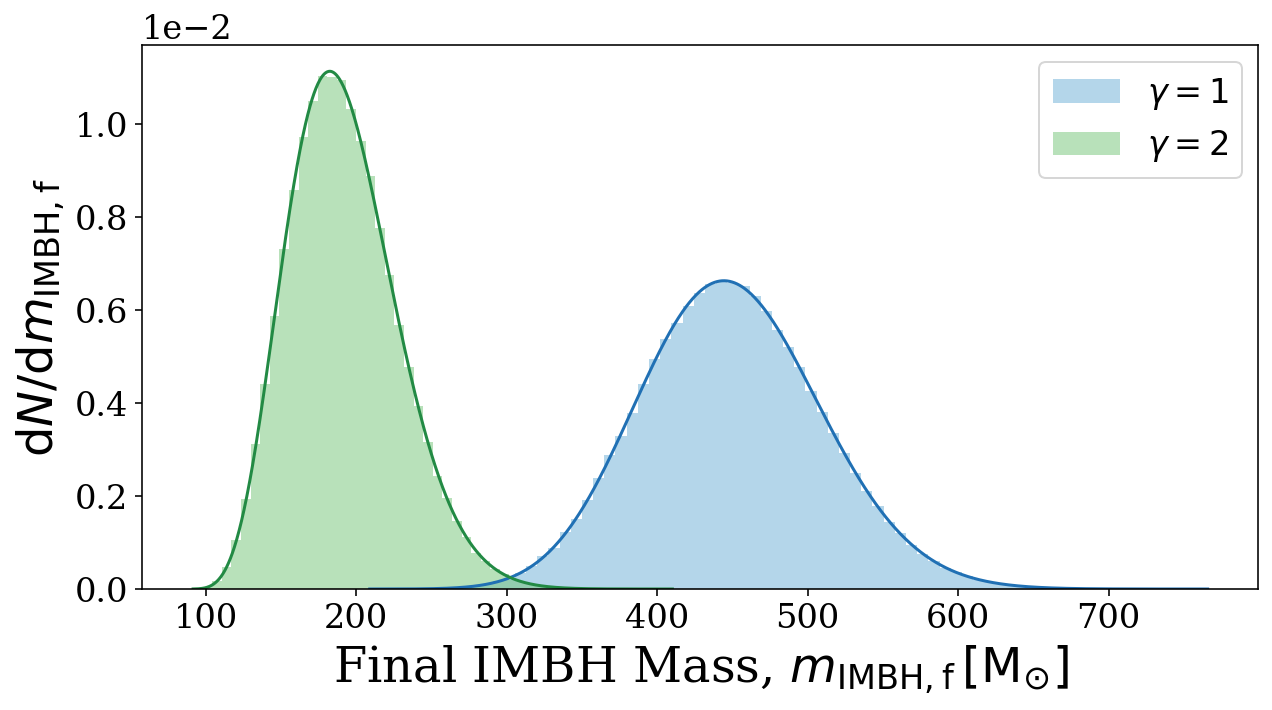

In [41]:
fig, ax = plt.subplots(1, figsize=(10, 5))

a, b, loc, scale = final_oligarch_g1_dist
x = np.linspace(np.min(final_oligarch_g1_sample.value), np.max(final_oligarch_g1_sample.value), 1000)
ax.hist(final_oligarch_g1_sample.value, bins=75, density=True, color=plt.get_cmap("Blues")(0.5), alpha=0.5, label=r"$\gamma=1$")
ax.plot(x, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale), color=plt.get_cmap("Blues")(0.75))

a, b, loc, scale = final_oligarch_g2_dist
x = np.linspace(np.min(final_oligarch_g2_sample.value), np.max(final_oligarch_g2_sample.value), 1000)
ax.hist(final_oligarch_g2_sample.value, bins=50, density=True, color=plt.get_cmap("Greens")(0.5), alpha=0.5, label=r"$\gamma=2$")
ax.plot(x, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale), color=plt.get_cmap("Greens")(0.75))

# a, b, loc, scale = final_oligarch_g2_TQM_dist
# x = np.linspace(np.min(final_oligarch_g2_TQM_sample.value), np.max(final_oligarch_g2_TQM_sample.value), 1000)
# ax.hist(final_oligarch_g2_TQM_sample.value, bins=50, density=True, color=plt.get_cmap("Purples")(0.5), alpha=0.5, label=r"TQM")
# ax.plot(x, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale), color=plt.get_cmap("Purples")(0.75))

ax.legend(fontsize=0.7*fs)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.set_xlabel(r"Final IMBH Mass, $m_{\rm IMBH, f} \, [\rm M_{\odot}]$", fontsize=fs)
ax.set_ylabel(r"$\mathrm{d} N / \mathrm{d} m_{\rm IMBH, f}$", fontsize=fs)
ax.tick_params(labelsize=0.7 * fs)

plt.show()

### Plot distributions

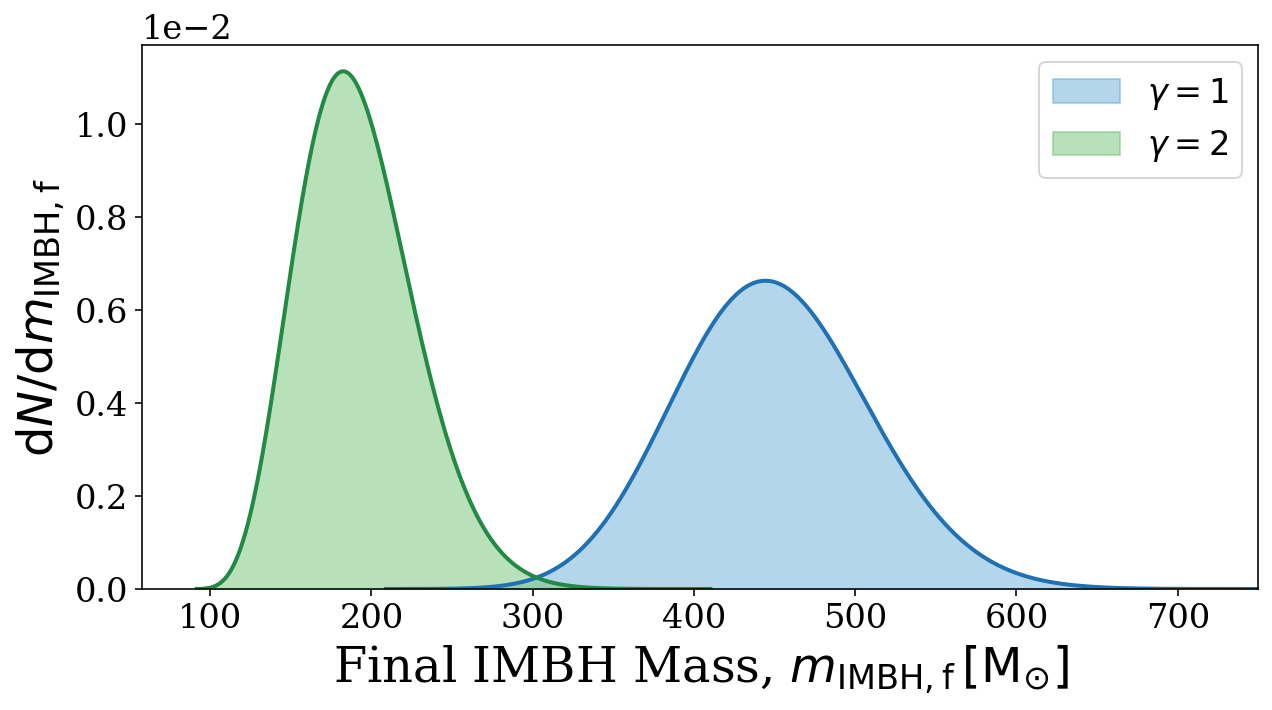

In [54]:
fig, ax = plt.subplots(1, figsize=(10, 5))

a, b, loc, scale = final_oligarch_g1_dist
x = np.linspace(np.min(final_oligarch_g1_sample.value), np.max(final_oligarch_g1_sample.value), 1000)
ax.plot(x, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale), color=plt.get_cmap("Blues")(0.75), lw=2)
ax.fill_between(x, 0, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale),
                color=plt.get_cmap("Blues")(0.5), alpha=0.5, label=r"$\gamma=1$")

a, b, loc, scale = final_oligarch_g2_dist
x = np.linspace(np.min(final_oligarch_g2_sample.value), np.max(final_oligarch_g2_sample.value), 1000)
ax.plot(x, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale), color=plt.get_cmap("Greens")(0.75), lw=2)
ax.fill_between(x, 0, stats.beta.pdf(x, a=a, b=b, loc=loc, scale=scale),
                color=plt.get_cmap("Greens")(0.5), alpha=0.5, label=r"$\gamma=2$")

ax.legend(fontsize=0.7*fs)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.set_ylim(bottom=0.0)
ax.set_xlim(right=750)

ax.set_xlabel(r"Final IMBH Mass, $m_{\rm IMBH, f} \, [\rm M_{\odot}]$", fontsize=fs)
ax.set_ylabel(r"$\mathrm{d} N / \mathrm{d} m_{\rm IMBH, f}$", fontsize=fs)
ax.tick_params(labelsize=0.7 * fs)

plt.savefig("../plots/final_oligarch_mass.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Horizon Distance Contours

In [143]:
f_range = np.logspace(-4, -1, 1000) * u.Hz
mc_range = np.logspace(0, np.log10(200), 250) * u.Msun

F, MC = np.meshgrid(f_range, mc_range)
F, MC = F.flatten(), MC.flatten()

q = 0.1
m_1 = MC * (1 + q)**(1/5) / q**(3/5)
m_2 = q * m_1

dist = np.repeat(8, len(m_1)) * u.kpc
ecc = np.repeat(0.3, len(m_1))

In [144]:
sources = legwork.source.Source(m_1=m_1, m_2=m_2, f_orb=F, ecc=ecc, dist=dist)

In [145]:
start = time.time()
snr = sources.get_snr(verbose=True)
print(time.time() - start)

Calculating SNR for 250000 sources
	119530 sources are stationary
		119530 sources are stationary and eccentric
	130470 sources are evolving
		130470 sources are evolving and eccentric
132.15950298309326


In [146]:
start = time.time()
t_merge = legwork.evol.get_t_merge_ecc(ecc_i=ecc, m_1=m_1, m_2=m_2, f_orb_i=F)
print(time.time() - start)

64.02883195877075


In [147]:
np.max(snr / 7 * 8 * u.kpc).to(u.Gpc)

<Quantity 7.31895303 Gpc>

In [169]:
def fmt_time(x):
    if x == 4:
        return r"$T_{\rm obs} = 4 \, \rm{yr}$"#"LISA Misson time"
    elif x >= 1e9:
        return "{0:1.0f} Gyr".format(x / 1e9)
    elif x >= 1e6:
        return "{0:1.0f} Myr".format(x / 1e6)
    elif x >= 1e3:
        return "{0:1.0f} kyr".format(x / 1e3)
    elif x >= 1:
        return "{0:1.0f} yr".format(x)
    elif x >= 1/12:
        return "{0:1.0f} month".format(x * 12)
    elif x >= 1/52:
        return "{0:1.0f} week".format(x * 52)
    else:
        return "{0:1.0f} day".format(x * 365)
    
def fmt_dist(x):
    if x >= 1e9:
        return "{0:1.0f} Gpc".format(x / 1e9)
    elif x >= 1e6:
        return "{0:1.0f} Mpc".format(x / 1e6)
    elif x >= 1e3:
        return "{0:1.0f} kpc".format(x / 1e3)
    else:
        return "{0:1.0f} pc".format(x)

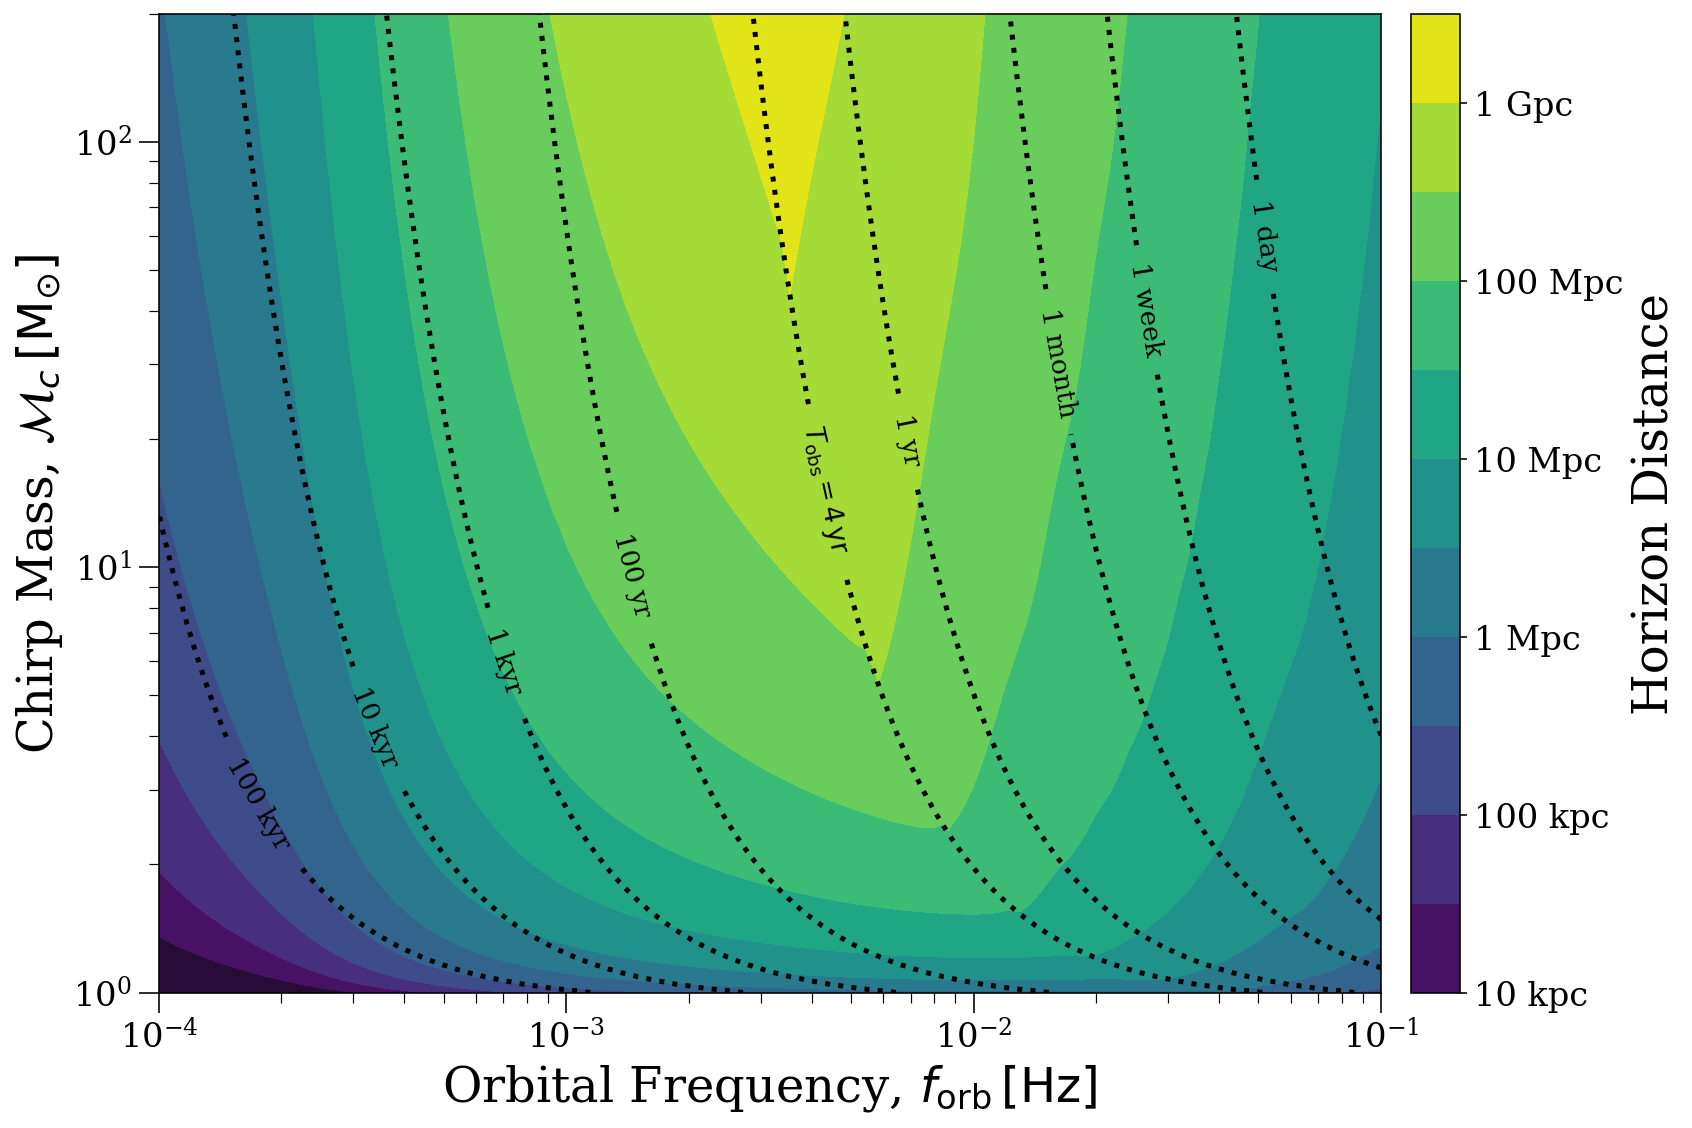

In [177]:
fig, ax = plt.subplots(figsize=(12, 8))

# if not distance contour levels provided, create our own sensible ones
distance_levels = np.arange(1, 6.5 + 0.5, 0.5)
distance_tick_levels = distance_levels[::2]

# zero messes with log so just make those super small and plot
# hor_dist[hor_dist <= 0.0] = 1e-9
dist_cont = ax.contourf(f_range.value, mc_range.value, np.log10(hor_dist.to(u.kpc).value), levels=distance_levels)

# create colourbar and label ticks accordingly
cbar = fig.colorbar(dist_cont, ax=ax, pad=0.02, ticks=distance_tick_levels)
cbar.ax.set_yticklabels([fmt_dist(np.power(10, distance_tick_levels + 3)[i]) for i in range(len(distance_tick_levels))])
cbar.set_label(r"Horizon Distance", fontsize=fs)
cbar.ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)

# set scaling
ax.set_xscale("log")
ax.set_yscale("log")

# change labels and fontsize
ax.tick_params(axis="both", which="major", labelsize=0.7 * fs, length=10)
ax.tick_params(axis="both", which="minor", labelsize=0.5 * fs, length=5)
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb} \, [\rm Hz]$")
ax.set_ylabel(r"Chirp Mass, $\mathcal{M}_{c} \, [\rm M_{\odot}]$")
bg_colour="#270c38"
ax.set_facecolor(bg_colour)

time_levels = [1/365, 1/52, 1/12, 1, 4,
               1e2, 1e3, 1e4, 1e5]

manual_time_locs = [(5e-2, 6e1), (2.5e-2, 4e1), (1.5e-2, 3e1), (7e-3, 2e1), (4e-3, 1.5e1),
                    (1.7e-3, 1e1), (7e-4, 6e0), (3e-4, 4e0), (2e-4, 3e0)]

time_cont = ax.contour(f_range.value, mc_range.value, t_merge_shaped.to(u.yr).value,
                       norm=matplotlib.colors.LogNorm(), levels=time_levels, 
                       colors="black", linewidths=2.5, linestyles="dotted")

# print(time_cont.collections[0].get_paths()[0].vertices)

ax.clabel(time_cont, time_cont.levels, fmt=fmt_time, fontsize=0.55*fs,
          use_clabeltext=True, manual=manual_time_locs)

plt.tight_layout()

# ax.grid(which="both", color="black")

plt.savefig("../plots/hor_dist_contours.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [178]:
n_AGN = 1000
AGN_age = np.random.rand(n_AGN) * u.Myr
t_encounter_to_merge = np.random.rand(n_AGN) * u.Myr / (15 * 3)
t_since_encounter = np.random.rand(n_AGN) * t_encounter_to_merge